# 运行时配置


In [38]:
! pip install -U langgraph langchain_core langchain_openai

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 定义两个大模型


In [39]:
import os

os.environ['API_BASE_URL'] = 'https://api.siliconflow.cn/v1'
os.environ['API_KEY'] = 'sk-ergndkhlwwhopjyicyysufmfkvbmjxmdcvwlbxvnoloduita'
os.environ['DEEPSEEK_MODEL_NAME'] = 'deepseek-ai/DeepSeek-V3'
os.environ['K2_MODEL_NAME'] = 'moonshotai/Kimi-K2-Instruct'

from langchain_openai import ChatOpenAI


deepseek_model = ChatOpenAI(api_key=os.getenv('API_KEY'),
                            model_name=os.getenv('DEEPSEEK_MODEL_NAME'),
                            base_url=os.getenv('API_BASE_URL'),
                            )

k2_model = ChatOpenAI(api_key=os.getenv('API_KEY'),
                            model_name=os.getenv('K2_MODEL_NAME'),
                            base_url=os.getenv('API_BASE_URL'),
                            )


models = {
    'deepseek': deepseek_model,
    'k2': k2_model
}


## 定义节点和边


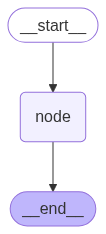

In [40]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class State(TypedDict):
    message: str
    result: str

def node(state: State, config: RunnableConfig) -> str:
    print("In node with model config: ", config["configurable"]["model"])

    model_name = config["configurable"].get("model", "deepseek")
    model_llm = models.get(model_name)

    result = model_llm.invoke(state['message'])
    state['result'] = result

    return {
        "message": state['message'],
        "result": state['result']
    }


builder = StateGraph(State)
builder.add_node('node', node)

builder.add_edge(START, 'node')
builder.add_edge('node', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

## 调用


In [41]:
# 测试修复后的代码 - DeepSeek模型
result = graph.invoke({"message": "你是什么大模型呢？"}, {"configurable": {"model": "deepseek"}})
print("DeepSeek模型完整结果:", result)
print("DeepSeek模型回复:", result['result'].content if hasattr(result['result'], 'content') else result['result'])

print("\n" + "="*50 + "\n")

# 测试K2模型
result_k2 = graph.invoke({"message": "你是什么大模型呢？"}, {"configurable": {"model": "k2"}})
print("K2模型完整结果:", result_k2)
print("K2模型回复:", result_k2['result'].content if hasattr(result_k2['result'], 'content') else result_k2['result'])

In node with model config:  deepseek
DeepSeek模型完整结果: {'message': '你是什么大模型呢？', 'result': AIMessage(content='我是 **DeepSeek Chat**，由 **深度求索（DeepSeek）公司**研发的智能对话大模型。我是基于 **DeepSeek-V3** 版本，具备强大的自然语言理解与生成能力，能够处理 **128K 上下文信息**，支持 **文件上传**（如 PDF、Word、Excel 等），并且能够帮你解答各种问题、分析数据、写作创意内容等！  \n\n我是 **免费** 使用的，目前没有收费计划，希望能给你带来流畅且高效的 AI 助手体验！😊  \n\n有什么我可以帮你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 121, 'prompt_tokens': 9, 'total_tokens': 130, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek-ai/DeepSeek-V3', 'system_fingerprint': '', 'id': '0198933558b468ffb6e612f9601a119e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--917e0de9-a7ac-484b-b8d5-90fc0e597303-0', usage_metadata={'input_tokens': 9, 'output_tokens': 121, 'total_tokens': 130, 'input_token_details': {}, 'output_token_details': {}})}
DeepSeek模型回复: 我是 **DeepSeek Chat**，由 **深度求索（DeepSeek）公司**研发的智能对话大模型。我是基于 **DeepSee